# Groover Technical test

This notebook presents the results obtained in the context of the Groover data science internship test by Julien Guinot. Part 1 is a summarization of a research paper which can be found in pdf file in the directory in which this notebook was sent

## Part 2

In part 2, we are provided with 19 raw WAV files containing samples of music from the Groover library. All samples are exactly 30s long, which is advantageous as we will not be having to conduct further padding to reach fixed-length input for our feature extraction model. Our goal is to extract audio features to be later used for a given machine learning task.

That being said, we are looking to extract audio features which are crucial for classification tasks or recommendation tasks. many common audio features exist, including but not limited to:

- Mel frequency cepstral coefficients, a representation of the spectral envelope of an audio signal
- Tempo, which is crucial to genre classification
- Spectrogram
- Spectral Centroid
- Zero crossing rate
- Spectral bandwidth
- Total harmonic distortion
- etc.

We will be building a dataset comprised of audio features for both song level and beat level features. This means we will compute the features for each song (30s clip), attribute a tempo to the song and split the signal according to this evaluated tempo, and re-compute the features for each beat split from the original signal. This will provide a global feature value for each clip and also allow us to look into more detail, which will be useful for tasks such as chorus loudness analysis when compared to the verse.

All this can be achieved using the Librosa library, which is particularly adapted for audio signal feature extraction tasks.

## Part 3

For part 3, we are provided with a pre-constructed dataset of audio features for 1000 fixed length songs. the goal here is to build a genre classification model based on the provided features with respect to the single-label ground truth column  in the dataset, which will be explored later. To do this, we will:

- Have a preliminary section of exploratory data analysis on the features of the provided dataset # almost done
- Consider relevant features and/or feature engineering opportunities 
- Conduct pre-processing, including but not limited to : cleaning the data, scaling the data, augmenting the data # almost done
- Split the data into training, test, and validation data (consider K-fold validation for optimal model selection) # almost done
- establish relevant training metrics for multi-class classification problem) # almost done
- Establish a baseline using common out-of-the-box classification models (logistic regression, naive bayes, random forest, MLP...) # almost done
- Select a few models to fine-tune
- Conduct a grid search for optimal hyperparameters on the selected model
- Compare our final most relevant model's results with the others and perhaps with state of the art models





In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
import keras
import sklearn
import librosa

sns.set_style('whitegrid')

## Part 2

In [1]:
from src.Audio_proc_utils import AudioFeatureExtractor

In [2]:
extractor = AudioFeatureExtractor()

In [3]:
dataset = extractor.build_30s_dataset()

In [4]:
dataset

,filename,uuid,duration,zero_crossing_rate,tempo,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,...,mfcc_15_mean,mfcc_15_std,mfcc_16_mean,mfcc_16_std,mfcc_17_mean,mfcc_17_std,mfcc_18_mean,mfcc_18_std,mfcc_19_mean,mfcc_19_std
0,music0,38842990-5862-11ec-b635-683e267ca217,30.013333,0.051973,83.354335,0.077110,0.077108,1198.459085,402.342968,1573.500275,...,3.292786,10.795691,-4.524483,11.753172,0.496720,10.288208,5.921975,11.868930,3.214540,13.041427
1,music1,396a3b71-5862-11ec-8a0d-683e267ca217,30.013333,0.092525,135.999178,0.136321,0.021771,2278.961252,413.395578,2375.248703,...,12.336756,7.828080,0.020517,8.563534,-0.743094,7.499599,-5.130959,9.796183,3.297938,9.621299
2,music10,3a07dd23-5862-11ec-911e-683e267ca217,30.013333,0.120721,123.046875,0.116129,0.059247,2564.319118,941.632204,2669.929254,...,-5.582714,6.578036,-4.691309,5.473560,-2.714943,6.238592,-1.851295,7.699596,-3.103203,5.479458
3,music11,3aa908a3-5862-11ec-8a5f-683e267ca217,30.013333,0.173752,123.046875,0.115771,0.050087,3256.774035,623.423031,2898.215061,...,-1.191364,6.848310,-4.374083,6.227931,-3.646294,7.037104,-2.083611,7.434423,-0.307833,7.560038
4,music12,3b4cf192-5862-11ec-8a53-683e267ca217,30.013333,0.075397,99.384014,0.173576,0.079108,2025.565006,712.336703,2272.735163,...,2.990675,7.298775,-4.508060,7.767137,4.687869,7.235426,-4.113947,7.940424,-2.781825,7.834619
5,music13,3bec5dd7-5862-11ec-9aae-683e267ca217,30.648889,0.119366,92.285156,0.186940,0.106910,2702.621720,838.109482,2666.607228,...,-2.565035,7.876284,-5.015092,7.658911,-3.964157,8.482578,-5.721850,9.605773,-0.039239,8.923325
6,music14,3c8c5a14-5862-11ec-bc48-683e267ca217,30.013333,0.126236,112.347147,0.124219,0.043118,3258.415438,915.053402,3321.430743,...,-1.519864,6.156345,-2.561921,5.998104,-1.190952,5.282491,-2.197093,5.324039,-1.882875,5.772631
7,music15,3d2bb600-5862-11ec-b7db-683e267ca217,30.013333,0.032963,107.666016,0.027120,0.016723,1171.224448,341.610494,1678.194616,...,-0.193916,9.005673,1.979718,10.425223,2.710432,9.650333,1.763512,8.263867,0.461243,9.237658
8,music16,3dc94c9f-5862-11ec-bdcc-683e267ca217,30.013333,0.079349,99.384014,0.130073,0.039918,1759.486745,516.643390,1779.599008,...,-2.725682,9.550074,1.133981,9.993067,-5.593521,9.261439,-2.763469,9.995333,-7.144936,11.606464
9,music17,3e69fb13-5862-11ec-8a54-683e267ca217,30.000181,0.137010,99.384014,0.140006,0.050015,2835.103815,661.480356,2731.718955,...,-0.408881,5.955102,-1.235823,5.830957,-0.754786,5.741117,-1.702523,6.052406,-1.038756,7.146235


## Part 3

In [2]:
dataset = pd.read_csv('data/part3_GrooverChallengeDataset.csv')

In [3]:
dataset

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [4]:
dataset.columns

Index(['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'label'

In [5]:
dataset.label.unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [6]:
dataset.length.unique()

array([661794, 669680, 661676, 665280, 661760, 663520, 661408, 661344,
       670120, 672282, 663080, 663300, 666820, 668800, 661100, 663740,
       664180, 666160, 668140, 667920, 665060, 661504, 664400, 669240,
       660000, 667700, 675808, 665940, 662112, 672100, 661980, 667480,
       661500, 670340, 669460], dtype=int64)

<AxesSubplot:xlabel='label', ylabel='length'>

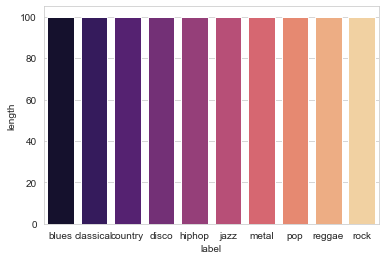

In [7]:
sns.barplot(data=dataset.groupby('label').count().length.reset_index(),x='label',y='length', palette='magma')

<AxesSubplot:xlabel='tempo', ylabel='Density'>

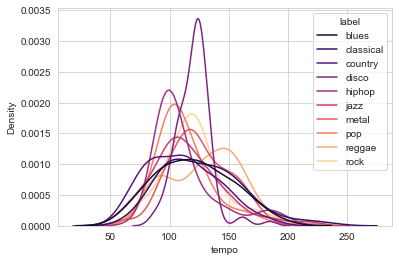

In [8]:
sns.kdeplot(data=dataset,x='tempo',hue='label',palette='magma')

### Data pre-processing

#### Min-max scaling, one-hot encoding and label encoding

In [9]:
features = dataset.drop(columns=['label'])
gt  = dataset.label

In [10]:
le = sklearn.preprocessing.LabelEncoder()
ohe = sklearn.preprocessing.LabelBinarizer()
y_labels = le.fit_transform(gt)
y_ohe = ohe.fit_transform(y_labels)

In [11]:
mms = sklearn.preprocessing.MinMaxScaler()
X = mms.fit_transform(features)

#### Train-test-validation split

We use a 60-20-20 train-test-validation due to the low amount of data we have (1000 samples)

In [12]:
from src.Preproc_utils import train_test_val_split

X_train,X_test,X_val,y_train,y_test,y_val = train_test_val_split(X,y_labels,train_size=.6)

### metrics

#### Multiclass classification metrics

The usual multiclass classification metrics are the following

- global accuracy
- macro-averaged precision, recall, f1 score
- confusion matrix

In our case, recall is the sub-metric which interests us the most, as it represents the percentage of the time the model is able to predict each class wheren presented with a positive sample for the class. Essentially, our use case makes us consider the optimal model to be one that does not overshoot but retrieves the correct genre often when presented with each genre, with oppiosition to precision, which minimises false predictions.

### Testing some out-of-the-box models

#### non-multioutput

In [13]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "poly SVM",
    "sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "Naive Bayes",'logreg','MLP'
]

out_of_the_box = [KNeighborsClassifier(3),
                  SVC(kernel="linear", C=0.025),
                  SVC(gamma=2, C=1),
                  SVC(kernel="poly", C=0.025),
                  SVC(kernel="sigmoid", C=0.025),
                  DecisionTreeClassifier(max_depth=5),
                  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                  GaussianNB(),LogisticRegression(),MLPClassifier((100,50,20))]

In [14]:
from src.Evaluation_utils import score_classifier
from src.Training_utils import plot_learning_curve

In [16]:
out_of_the_box_results = []

for classifier in out_of_the_box:
    classifier.fit(X_train,y_train)
    out_of_the_box_results.append(list(score_classifier(classifier,X_test,y_test)))

out_of_the_box_results = pd.DataFrame(out_of_the_box_results,columns = ['accuracy','precision','recall','f1'],index=names)

C:\Users\Administrator_juj\anaconda3\envs\Groovrtest\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator_juj\anaconda3\envs\Groovrtest\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator_juj\anaconda3\envs\Groovrtest\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: Convergence

In [17]:
out_of_the_box_results

,accuracy,precision,recall,f1
Nearest Neighbors,0.620,0.620,0.648399,0.613997
Linear SVM,0.450,0.450,0.497389,0.420669
RBF SVM,0.725,0.725,0.741162,0.727882
poly SVM,0.580,0.580,0.562823,0.563225
sigmoid SVM,0.205,0.205,0.146765,0.137701
Decision Tree,0.540,0.540,0.591870,0.537247
Random Forest,0.490,0.490,0.462370,0.456078
Naive Bayes,0.525,0.525,0.549381,0.521509
logreg,0.660,0.660,0.656074,0.653271
MLP,0.740,0.740,0.741622,0.738046


#### multioutput

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression